In [ ]:
!pip install contractions

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.3/118.3 kB 6.2 MB/s eta 0:00:00


In [ ]:
!pip install --upgrade tensorflow tensorflow-hub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 22.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.5/615.5 MB 2.5 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.18.0
    Uninstalling tensorflow-2.18.0:
      Successfully uninstalled tensorflow-2.18.0


In [158]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.optim as optim

import tensorflow as tf
import tensorflow_hub as hub

import nltk
nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize

import re

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

seed = 42
torch.manual_seed(seed)

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


## Load Data and EDA

In [159]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [160]:
train = pd.read_csv('/content/drive/My Drive/code/Tweet/train.csv', encoding='latin-1')
test = pd.read_csv('/content/drive/My Drive/code/Tweet/test.csv', encoding='latin-1')

In [161]:
train.head()

,textID,text,selected_text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,morning,0-20,Afghanistan,38928346,652860.0,60
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,noon,21-30,Albania,2877797,27400.0,105
2,088c60f138,my boss is bullying me...,bullying me,negative,night,31-45,Algeria,43851044,2381740.0,18
3,9642c003ef,what interview! leave me alone,leave me alone,negative,morning,46-60,Andorra,77265,470.0,164
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,noon,60-70,Angola,32866272,1246700.0,26


In [162]:
train.dropna(inplace=True)
test.dropna(inplace=True)
train.drop_duplicates(inplace=True)
test.drop_duplicates(inplace=True)

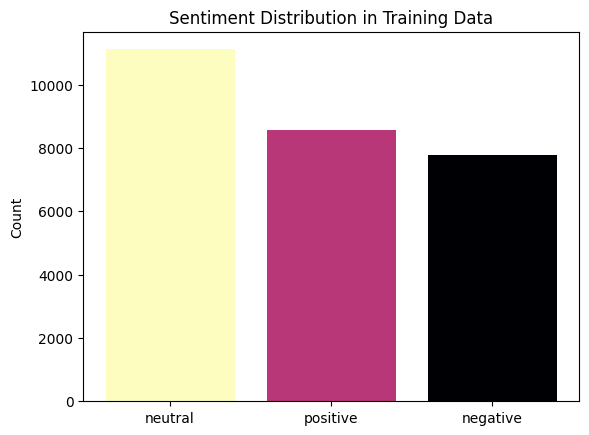

In [163]:
sentiment_counts = train['sentiment'].value_counts()

ranks = np.argsort(np.argsort(sentiment_counts.values))
colors = plt.cm.magma (ranks / max(ranks))

plt.bar(sentiment_counts.index, sentiment_counts.values, color=colors)
plt.ylabel("Count")
plt.title("Sentiment Distribution in Training Data")
plt.show()

Use only text and sentiment columns

In [164]:
col = ['text', 'sentiment']

train_df = train[col]
test_df = test[col]

## Prepare Sentiment Labels

In [165]:
sentiment_to_index = {
    'negative': 0,
    'neutral': 1,
    'positive': 2
  }

train_df.loc[:, 'sentiment'] = train_df['sentiment'].map(sentiment_to_index)
test_df.loc[:, 'sentiment'] = test_df['sentiment'].map(sentiment_to_index)

In [166]:
train_df.head()

,text,sentiment
0,"I`d have responded, if I were going",1
1,Sooo SAD I will miss you here in San Diego!!!,0
2,my boss is bullying me...,0
3,what interview! leave me alone,0
4,"Sons of ****, why couldn`t they put them on t...",0


## Prepare Text Data

### Adjust Words based on REGEX

In [167]:
def remove_special_character(text):
    text=re.sub('<.*?>', ' ', text)
    text=re.sub('<.*>','',text)
    text=re.sub('http\S+|https\S+|www\S+','',text)
    text=re.sub('@\S+|#\S+','',text)
    # Keep apostrophes only if inside words (like "I'm", "don't")
    text = re.sub('`', "'",  text)
    text = re.sub(r"[^\w\s']", '', text)
    return text

In [168]:
import contractions

# couldn't -> could not
def expand_contractions(text):
    text = contractions.fix(text)
    return text

In [169]:
train_df.loc[:, 'text'] = train_df['text'].str.lower().str.strip().apply(remove_special_character).apply(expand_contractions)
test_df.loc[:, 'text'] = test_df['text'].str.lower().str.strip().apply(remove_special_character).apply(expand_contractions)

In [170]:
train_df.head()

,text,sentiment
0,i would have responded if i were going,1
1,sooo sad i will miss you here in san diego,0
2,my boss is bullying me,0
3,what interview leave me alone,0
4,sons of why could not they put them on the re...,0


### Tokenize

In [171]:
train_data = []

for _, row in train_df.iterrows():
    text = row["text"]
    tokens = word_tokenize(text)
    train_data.append([row["sentiment"], tokens])

In [172]:
train_data[:3]

[[1, ['i', 'would', 'have', 'responded', 'if', 'i', 'were', 'going']],
 [0,
  ['sooo', 'sad', 'i', 'will', 'miss', 'you', 'here', 'in', 'san', 'diego']],
 [0, ['my', 'boss', 'is', 'bullying', 'me']]]

In [173]:
test_data = []

for _, row in test_df.iterrows():
    text = row["text"]
    tokens = word_tokenize(text)
    test_data.append([row["sentiment"], tokens])

In [174]:
test_data[:3]

[[1, ['last', 'session', 'of', 'the', 'day']],
 [2,
  ['shanghai',
   'is',
   'also',
   'really',
   'exciting',
   'precisely',
   'skyscrapers',
   'galore',
   'good',
   'tweeps',
   'in',
   'china',
   'sh',
   'bj']],
 [0,
  ['recession',
   'hit',
   'veronique',
   'branquinho',
   'she',
   'has',
   'to',
   'quit',
   'her',
   'company',
   'such',
   'a',
   'shame']]]

### Remove stop words and Apply Lemmatizer

In [175]:
from nltk.corpus import stopwords
nltk.download('stopwords')
import spacy

nlp = spacy.load('en_core_web_sm')
stop_words = set(stopwords.words("english"))

def preprocess_tokens(tokens):
    processed_tokens = []
    for token_list in tokens:
        label, words = token_list[0], token_list[1]
        filtered_words = [word for word in words if word not in stop_words]  # Remove stopwords

        lemmatized_words = []
        for doc in nlp.pipe(filtered_words, disable=["parser", "ner"]):
            lemmatized_words.append(doc[0].lemma_)

        processed_tokens.append([label, lemmatized_words])
    return processed_tokens

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [176]:
train_processed = preprocess_tokens(train_data)
train_processed[:5]

[[1, ['would', 'respond', 'go']],
 [0, ['sooo', 'sad', 'miss', 'san', 'diego']],
 [0, ['boss', 'bully']],
 [0, ['interview', 'leave', 'alone']],
 [0, ['son', 'could', 'put', 'release', 'already', 'buy']]]

In [177]:
test_processed = preprocess_tokens(test_data)
test_processed[:5]

[[1, ['last', 'session', 'day']],
 [2,
  ['shanghai',
   'also',
   'really',
   'exciting',
   'precisely',
   'skyscraper',
   'galore',
   'good',
   'tweep',
   'china',
   'sh',
   'bj']],
 [0,
  ['recession', 'hit', 'veronique', 'branquinho', 'quit', 'company', 'shame']],
 [2, ['happy', 'birthday']],
 [2, ['like']]]

### Prepare Dataset

#### Training and Validation

In [178]:
train_text = [" ".join(tokens) for _, tokens in train_data]
train_label = np.array([label for label, _ in train_data])

In [179]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_text, train_label))

# Shuffle the entire dataset
train_dataset = train_dataset.shuffle(len(train_text), seed=42)

train_ratio = 0.9
total_size = len(train_text)
train_size = int(train_ratio * total_size)

train_data2 = train_dataset.take(train_size)
val_data2 = train_dataset.skip(train_size)

train_data2 = train_data2.map(lambda x, y: (tf.squeeze(x), y)).batch(32).prefetch(tf.data.AUTOTUNE)
val_data2 = val_data2.map(lambda x, y: (tf.squeeze(x), y)).batch(1).prefetch(tf.data.AUTOTUNE)

#### Get Vocab

In [180]:
unique_words = set()

for batch in train_data2.as_numpy_iterator():
    text_batch, _ = batch
    for text in text_batch:
        words = text.decode().split()  # Convert tensor to string and split into words
        unique_words.update(words)

print(f"Vocabulary Size: {len(unique_words)}")

Vocabulary Size: 26223


#### Testing

In [181]:
test_text = [" ".join(tokens) for _, tokens in test_processed]
test_label = np.array([label for label, _ in test_processed])

In [182]:
test_dataset = tf.data.Dataset.from_tensor_slices((test_text, test_label))
test_data2 = test_dataset.shuffle(len(test_dataset)).batch(1)

## Data Prediction

### Embed text

In [183]:
embedding_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
hub_layer = hub.KerasLayer(embedding_url, input_shape=[], dtype=tf.string, trainable=True)

#### Example of how data is embedded

In [184]:
hub_layer(list(train_text[0][0]))

<tf.Tensor: shape=(1, 512), dtype=float32, numpy=
array([[ 0.00385028, -0.0604663 ,  0.0558984 ,  0.03616686, -0.00504892,
         0.06033555,  0.04691034,  0.002513  ,  0.06776612,  0.01976442,
         0.06982863,  0.03862406,  0.05305007,  0.10519341, -0.00747498,
         0.01348311, -0.02168598,  0.04999107,  0.00855012,  0.00024741,
        -0.0674442 , -0.01520991,  0.00391793,  0.0381768 , -0.04860223,
         0.02571548, -0.0431549 , -0.05009422,  0.07442304, -0.04567593,
        -0.03147096,  0.02006959, -0.0033605 , -0.00279257, -0.01892711,
        -0.02840253,  0.02533041,  0.07861065, -0.00226228, -0.01516857,
        -0.03405167,  0.00161463,  0.00021469,  0.02874378,  0.01199982,
         0.04725197, -0.05593035, -0.06020663, -0.04509259, -0.05578887,
        -0.0504543 , -0.0358163 ,  0.09064268,  0.10568638,  0.0050394 ,
        -0.02213588,  0.0941473 ,  0.01236431,  0.03946306, -0.00370715,
        -0.01451703,  0.00567631,  0.03853788,  0.03905071,  0.00655682,
 

In [185]:
from tensorflow.keras.layers import Layer

# Wrap hub.KerasLayer inside a Custom Layer
class HubEmbeddingLayer(Layer):
    def __init__(self, hub_layer):
        super(HubEmbeddingLayer, self).__init__()
        self.hub_layer = hub_layer

    def call(self, inputs):
        return self.hub_layer(inputs)

In [186]:
# Define GELU activation function
gelu = tf.keras.layers.Activation(tf.nn.gelu)

model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(shape=(), dtype=tf.string), # Explicit input layer
    HubEmbeddingLayer(hub_layer), # Pretrained embedding layer

    # First dense block
    tf.keras.layers.Dense(256),
    tf.keras.layers.LayerNormalization(),
    gelu,
    tf.keras.layers.Dropout(0.4),

    # Residual connection
    tf.keras.layers.Dense(128),
    tf.keras.layers.LayerNormalization(),
    gelu,
    tf.keras.layers.Dropout(0.3),

    # Second dense block
    tf.keras.layers.Dense(64),
    tf.keras.layers.LayerNormalization(),
    gelu,
    tf.keras.layers.Dropout(0.2),

    # Third dense block
    tf.keras.layers.Dense(32),
    gelu,

    # Output layer
    tf.keras.layers.Dense(3, activation='softmax')
])

In [187]:
lr_schedule = tf.keras.optimizers.schedules.CosineDecayRestarts(
    initial_learning_rate=1e-3, first_decay_steps=1000, t_mul=2.0, m_mul=0.9
)


model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [188]:
model.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ hub_embedding_layer_11               │ (None, 512)                 │               0 │
│ (HubEmbeddingLayer)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_58 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_normalization_27               │ (None, 256)                 │             512 │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_10 (Activation)           │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_29 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_59 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_normalization_28               │ (None, 128)                 │             256 │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_10 (Activation)           │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_30 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_60 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_normalization_29               │ (None, 64)                  │             128 │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_10 (Activation)           │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_31 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_61 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_10 (Activation)           │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_62 (Dense)                     │ (None, 3)                   │              99 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 175,555 (685.76 KB)

 Trainable params: 175,555 (685.76 KB)

 Non-trainable params: 0 (0.00 B)

In [189]:
history = model.fit(train_data2, epochs=10, validation_data=val_data2)

Epoch 1/10
773/773 ━━━━━━━━━━━━━━━━━━━━ 44s 48ms/step - accuracy: 0.5872 - loss: 0.8693 - val_accuracy: 0.6892 - val_loss: 0.6966
Epoch 2/10
773/773 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.6943 - loss: 0.7082 - val_accuracy: 0.7213 - val_loss: 0.6531
Epoch 3/10
773/773 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.7017 - loss: 0.6835 - val_accuracy: 0.7424 - val_loss: 0.6014
Epoch 4/10
773/773 ━━━━━━━━━━━━━━━━━━━━ 38s 42ms/step - accuracy: 0.7193 - loss: 0.6575 - val_accuracy: 0.7289 - val_loss: 0.6173
Epoch 5/10
773/773 ━━━━━━━━━━━━━━━━━━━━ 40s 40ms/step - accuracy: 0.7154 - loss: 0.6636 - val_accuracy: 0.7544 - val_loss: 0.5988
Epoch 6/10
773/773 ━━━━━━━━━━━━━━━━━━━━ 41s 40ms/step - accuracy: 0.7212 - loss: 0.6434 - val_accuracy: 0.7671 - val_loss: 0.5608
Epoch 7/10
773/773 ━━━━━━━━━━━━━━━━━━━━ 32s 41ms/step - accuracy: 0.7366 - loss: 0.6125 - val_accuracy: 0.7806 - val_loss: 0.5313
Epoch 8/10
773/773 ━━━━━━━━━━━━━━━━━━━━ 44s 45ms/step - accuracy: 0.7489 - loss: 0.5900 - 

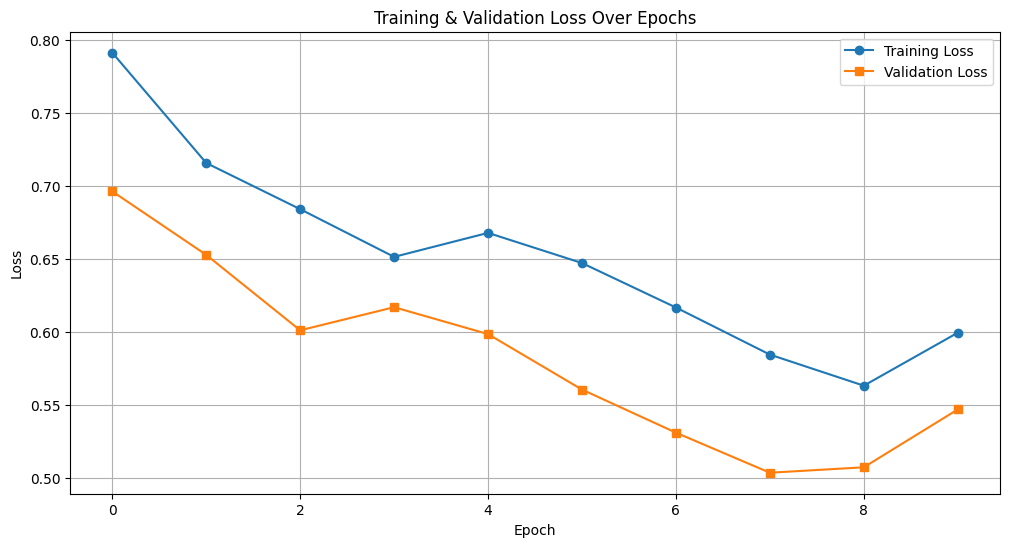

In [190]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='s')
plt.title('Training & Validation Loss Over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.grid()
plt.legend()
plt.show()

In [191]:
test_loss, test_acc = model.evaluate(test_data2, verbose=1)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

3534/3534 ━━━━━━━━━━━━━━━━━━━━ 24s 7ms/step - accuracy: 0.6926 - loss: 0.8014
Test Loss: 0.8539
Test Accuracy: 0.6737
